# <p style="text-align: center;"> PROJECT 11: MACHINE LEARNING</p>

### DESCRIPTION OF THE PROJECT:<BR>
 Mobile carrier Megaline has found out that many of their subscribers use legacy plans. They want to develop a model that would analyze subscribers' behavior and recommend one of Megaline's newer plans: Smart or Ultra.<BR>

 I have access to behavior data about subscribers who have already switched to the new plans.<BR>
 
 For this classification task, I need to develop a model that will pick the right plan. Since I’ve already performed the data preprocessing step, I can move straight to creating the model.  

### GOAL OF THE PROJECT:<BR>

Develop a model with the highest possible accuracy. In this project, the threshold for accuracy is 0.75. Check the accuracy using the test dataset.  

***

### <p style="text-align: center;"> 1. IMPORT LIBRARIES.</p>

In [2]:
# import libraries.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import chi2, SelectKBest, f_classif
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model
from scipy.stats import randint
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.ensemble import GradientBoostingClassifier

### <p style="text-align: center;"> 2. OPENING AND READING THE FILE.</p>

In [3]:
# reading the csv file.
users = pd.read_csv('/Users/cesarchaparro/Desktop/TripleTen/Sprint_11/project/users_behavior.csv')
users

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


#### Columns are clean.<br>
#### 3214 Users.<br>
#### We can see that users with Ultra plan are assigned with 1, and the users with Smart plan are assigned with 0 on the column.

In [4]:
# info method to see types of data and missing values.
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


#### Non missing values.

***

### <p style="text-align: center;"> 3. EXPLORATORY DATA ANALYSIS.</p>

In [5]:
# mean to see average values by plan group.
users.groupby(['is_ultra']).mean().T

is_ultra,0,1
calls,58.463437,73.392893
minutes,405.942952,511.224569
messages,33.384029,49.363452
mb_used,16208.466949,19468.823228


#### Users on the Ultra plan (is_ultra = 1) tend to have higher average usage across all metrics compared to users on the Smart plan (is_ultra = 0).

In [6]:
# calculate distribution by percentage by plan.
percentages = users.drop(columns = 'is_ultra').groupby(users['is_ultra']).sum() / users.drop(columns = 'is_ultra').sum() * 100
percentages.T

is_ultra,0,1
calls,64.319101,35.680899
minutes,64.246300,35.753700
messages,60.480672,39.519328
mb_used,65.325685,34.674315


#### Despite users on the Ultra plan having higher average usage, the total number of users on the Smart plan is likely much larger, which results in a higher overall contribution to the total calls, minutes, messages, and mb_used metrics.

#### We can also see differences on each feature for each plan, they are nor balance on the behavior.

In [7]:
# describe method for each separate group plan for individual analysis.
for group in users['is_ultra'].unique():
    if group == 1:
        result = 'Ultra'
    else:
        result = 'Smart'
    print("Basic statistics for", result, "group")
    print("===============================================")
    display(users[users.is_ultra == group].describe())

Basic statistics for Smart group


,calls,minutes,messages,mb_used,is_ultra
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.0
mean,58.463437,405.942952,33.384029,16208.466949,0.0
std,25.939858,184.512604,28.227876,5870.498853,0.0
min,0.000000,0.000000,0.000000,0.000000,0.0
25%,40.000000,274.230000,10.000000,12643.050000,0.0
50%,60.000000,410.560000,28.000000,16506.930000,0.0
75%,76.000000,529.510000,51.000000,20043.060000,0.0
max,198.000000,1390.220000,143.000000,38552.620000,0.0


Basic statistics for Ultra group


,calls,minutes,messages,mb_used,is_ultra
count,985.000000,985.000000,985.000000,985.000000,985.0
mean,73.392893,511.224569,49.363452,19468.823228,1.0
std,43.916853,308.031100,47.804457,10087.178654,0.0
min,0.000000,0.000000,0.000000,0.000000,1.0
25%,41.000000,276.030000,6.000000,11770.280000,1.0
50%,74.000000,502.550000,38.000000,19308.010000,1.0
75%,104.000000,730.050000,79.000000,26837.720000,1.0
max,244.000000,1632.060000,224.000000,49745.730000,1.0


#### Ultra users make significantly more calls on average than Smart users (73.39 vs. 58.46).<br>

- The distribution of calls among Ultra users is more spread out (higher standard deviation), indicating a wider variety in call behavior. Some users make very few calls, while others make a lot.<br>
- The median call number is also higher in the Ultra group, reinforcing that Ultra users generally engage in more calling activity.<br>
- Ultra users spend more time on the phone, with an average of 511.22 minutes compared to 405.94 minutes for Smart users.<br>
- The variation in minutes used is much higher in the Ultra group, suggesting diverse usage patterns (some users are heavy users while others are not).<br>
- The median number of minutes is higher for Ultra users, again showing that they tend to spend more time on calls.<br>
- Ultra users send more messages on average (49.36 vs. 33.38).<br>
- The standard deviation is also higher, indicating that while some Ultra users send very few messages, others send significantly more.<br>
- The median message count is higher for Ultra users, indicating that even the typical user in this group sends more messages than those in the Smart group.<br>
- Ultra users consume significantly more mobile data on average (19,468.82 MB vs. 16,208.47 MB).<br>
- The variation in data usage is notably higher among Ultra users, with some users consuming much more data than others.<br>
- The median data usage is higher for Ultra users, confirming that they generally consume more data than Smart users.<br>

#### The Ultra plan appears to attract users who have higher demands for calls, messaging, and data usage. The significant variation in usage among Ultra users suggests that this plan might be more flexible, appealing to both heavy and moderate users. In contrast, the Smart plan serves users with more consistent and generally lower usage needs. This analysis could inform marketing strategies, such as targeting different segments based on their usage patterns or adjusting pricing and features to better meet the needs of each group.

#### Correlation Matrix:<br>
#### It helps in identifying relationships between variables, detecting multicollinearity, reducing dimensionality, preprocessing data, gaining model insights, and detecting data issues. Understanding these correlations is foundational to building robust and interpretable machine learning model.

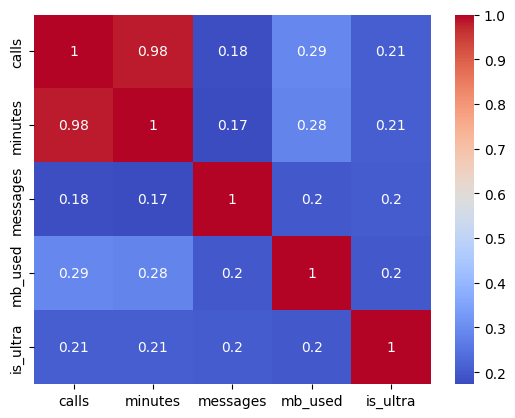

In [8]:
# calculate correlation matrix
correlation_matrix = users.corr()

# visualize the correlation matrix using a heatmap
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm')
plt.show()

#### The provided heatmap visualizes the correlation matrix among the variables: calls, minutes, messages, mb_used, and is_ultra. The color intensity represents the strength of the correlation, ranging from red (strong positive correlation) to blue (strong negative correlation).<br>

#### Calls and minutes exhibit a very strong positive correlation, as indicated by the intense red color. This suggests that users who make more calls tend to also have longer call durations.

#### Messages and minutes show a moderate positive correlation, implying that users who send more messages also tend to have longer call durations.<br>

#### There's a moderate positive correlation between mb_used and minutes, suggesting that users with higher data usage might also have longer calls.<br>

#### The relationship between calls, minutes, and messages with mb_used and is_ultra is relatively weak, as indicated by the lighter colors. This implies that these variables don't significantly influence data usage or ultra plan subscription.<br>

#### Since there are 2 features highly correlated, I will drop one of them on the below step.



In [9]:
clean_users = users.drop(['minutes'], axis=1)
clean_users.head()

,calls,messages,mb_used,is_ultra
0,40.0,83.0,19915.42,0
1,85.0,56.0,22696.96,0
2,77.0,86.0,21060.45,0
3,106.0,81.0,8437.39,1
4,66.0,1.0,14502.75,0


***

### <p style="text-align: center;"> 4. SPLIT THE SOURCE DATA INTO A TRAINING SET, A VALIDATION SET, AND A TEST SET.<br></p>

### 60% training dataset.<br>
### 20% validating dataset.<br>
### 20% test dataset.

In [10]:
train, valid = train_test_split(clean_users, test_size = 0.4, random_state = 42)
valid_set, test_set = train_test_split(valid, test_size = 0.5, random_state = 42)

In [11]:
train.shape

(1928, 4)

#### 60% for the training dataset is 1928.

In [12]:
valid.shape

(1286, 4)

In [13]:
display(valid_set.shape)
display(test_set.shape)

(643, 4)

(643, 4)

#### 20% for the validating dataset is 643.<br>

#### 20% for the test dataset is 643.

In [14]:
# divides a training dataset into features and a target variable.
features_train = train.drop('is_ultra', axis = 1)
target_train = train['is_ultra']
print(features_train.shape)
print(target_train.shape)

(1928, 3)
(1928,)


In [15]:
# divides a validation dataset into two parts: features and the target variable.
features_valid = valid_set.drop('is_ultra', axis = 1)
target_valid = valid_set['is_ultra']
print(features_valid.shape)
print(target_valid.shape)

(643, 3)
(643,)


In [16]:
# divides a test dataset into two parts: features and the target variable.
features_test = test_set.drop('is_ultra', axis = 1)
target_test = test_set['is_ultra']
print(features_test.shape)
print(target_test.shape)

(643, 3)
(643,)


***

### <p style="text-align: center;"> DECISION TREE<br></p>

#### Model Selection.

In [17]:
# creating the model.
dtc_model = DecisionTreeClassifier(random_state = 42)

#### Model Training.

In [18]:
# training on the training model.
dtc_model = dtc_model.fit(features_train,target_train)

#### Model Evaluation.

In [19]:
#fitting predictions on the valid
valid_pred = dtc_model.predict(features_valid)

In [20]:
# getting the accuracy score
score = dtc_model.score(features_valid, target_valid)
score  

0.7573872472783826

#### <span style="color:yellow"> Accuracy 0.75738

In [21]:
# plotting the decition tree.
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10,10), dpi = 300)

tree.plot_tree(dtc_model);

In [ ]:
# getting the maximum depth for the tree
dtc_model.tree_.max_depth

32

In [ ]:
# interating through a range to see the best accuracy.
final_depth = 0
final_score = 0
for depth in range(1, 10):
    dtc_model_b = DecisionTreeClassifier(random_state = 42, max_depth = depth)
    dtc_model_b.fit(features_train, target_train)
    valid_pred = dtc_model_b.predict(features_valid)
    accuracy = dtc_model_b.score(features_valid, target_valid)
    print("Final depth=", depth, "with accuracy:", accuracy)

Final depth= 1 with accuracy: 0.7558320373250389
Final depth= 2 with accuracy: 0.7916018662519441
Final depth= 3 with accuracy: 0.7962674961119751
Final depth= 4 with accuracy: 0.7822706065318819
Final depth= 5 with accuracy: 0.7916018662519441
Final depth= 6 with accuracy: 0.7838258164852255
Final depth= 7 with accuracy: 0.7884914463452566
Final depth= 8 with accuracy: 0.8133748055987559
Final depth= 9 with accuracy: 0.7978227060653188


#### <span style="color:yellow"> Best accuracy for Decition Tree with depth 8 = 0.81337

#### The Matthews correlation coefficient 

In [ ]:
# calculating the matthews correlation coeficient
def calculate_mcc(actual, predicted):
  mcc = matthews_corrcoef(actual, predicted)
  return mcc
mcc_value = calculate_mcc(target_valid, valid_pred)
print("MCC:", mcc_value)

MCC: 0.49191333700693857


#### A MCC value of 0.4919 indicates a moderate positive correlation between the predicted and actual values.



#### I will tune the model with the best hyperparameter found.

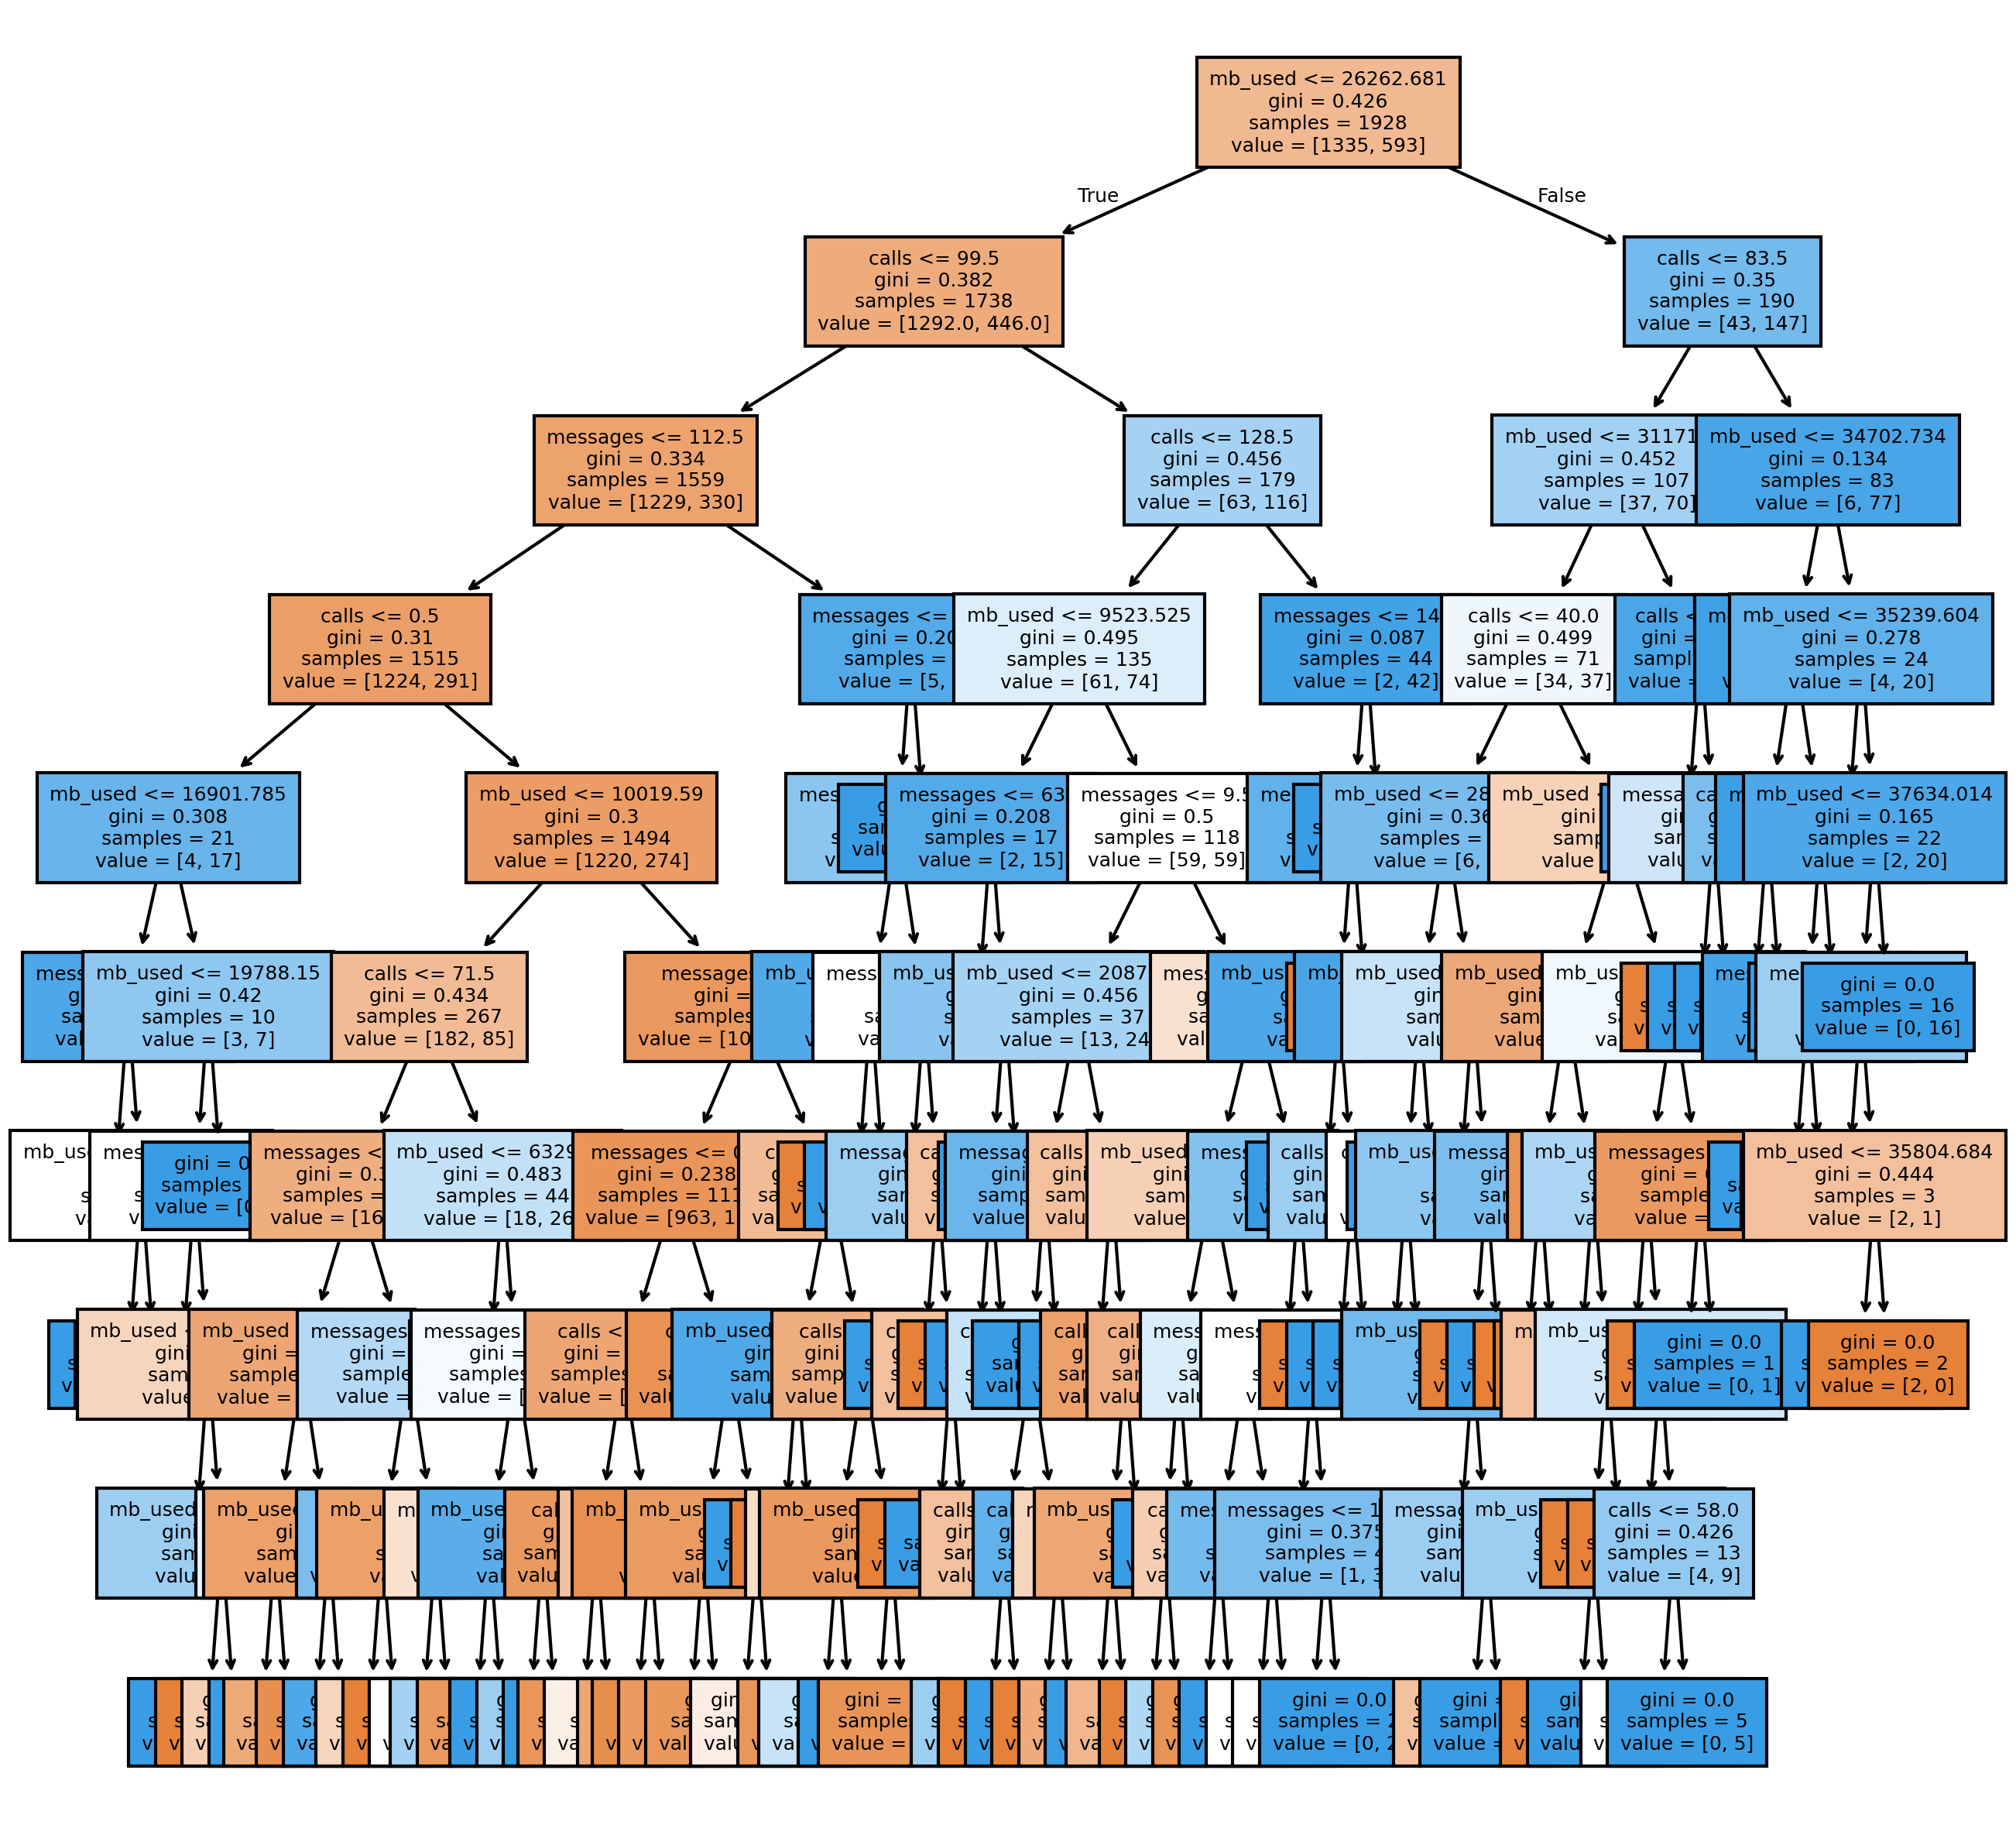

In [ ]:
# plotting the tuned decition tree.
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10,10), dpi = 300)
tree.plot_tree(dtc_model_b,feature_names = features_train.columns,filled = True, fontsize = 6);

#### When having a decision tree model and want to evaluate its performance, the confusion matrix helps understand the number of correct and incorrect predictions made by the model.

In [ ]:
# defining the confusion matrix.
cm = confusion_matrix(target_test, valid_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[356  92]
 [162  33]]


#### Analysis<br>
True Negatives (365): The model is good at correctly identifying negative cases.<br>

False Positives (83): There is a moderate number of negative cases being incorrectly classified as positive.<br>

False Negatives (159): The model is missing a significant number of positive cases, which could be problematic depending on the application.<br>

True Positives (36): The model is able to correctly identify some positive cases, but not very many.

#### Further tuning the model with other hyperparameters having in mind the confusion matrix results with class_weight parameter.

In [ ]:
# creating the model.
dtc_model_tuned = DecisionTreeClassifier(random_state = 42, class_weight={0: 1, 1: 3.1}, max_depth = 6)
# training on the training model.
dtc_model_tuned = dtc_model_tuned.fit(features_train, target_train)

In [ ]:
# model evaluation with the tuned model.
accuracy_tuned = dtc_model_tuned.score(features_valid, target_valid)
print("Accuracy:", accuracy_tuned)

Accuracy: 0.7791601866251944


#### <span style="color:yellow"> Accuracy: 0.77916

#### Variation of tuning for this model:

In [ ]:
# creating a param and then fitting it into the model
param_dist = {
    "max_depth": [3, None],
    "max_features": randint(1, 9),
    "min_samples_leaf": randint(1, 9),
    "criterion": ["gini", "entropy"]
}
 
tree = DecisionTreeClassifier()
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)
tree_cv.fit(features_train, target_train)
 
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 5}
Best score is 0.7878675728416662


In [ ]:
# testing for final evaluation and trained model. 
dtc_predictions_test = dtc_model_b.predict(features_test)
dtc_accuracy_test = accuracy_score(target_test, dtc_predictions_test)
print("Decision Tree testing score:", dtc_accuracy_test)   

Decision Tree testing score: 0.7962674961119751


#### <span style="color:yellow"> Accuracy: 0.79%

####  Gradient Boosting Classifier.

In [ ]:
# Initialize the Gradient Boosting model
gbc_model = GradientBoostingClassifier(random_state=42)

In [ ]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.05],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}


In [ ]:
# Set up GridSearchCV
grid_search = GridSearchCV(estimator = gbc_model, param_grid = param_grid, cv = 5, scoring = 'accuracy', n_jobs = -1, verbose = 2)

# Fit the model on the training data
grid_search.fit(features_train, target_train)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=

/Users/cesarchaparro/Documents/Sprint6pjt/.conda/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.05],
                         'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [ ]:
# Best parameters and model
best_params = grid_search.best_params_
best_gbc_model = grid_search.best_estimator_
print("Best Parameters found by Grid Search:", best_params)

# Evaluate the model on the validation set
valid_pred = best_gbc_model.predict(features_valid)
accuracy = best_gbc_model.score(features_valid, target_valid)
print("Validation Accuracy of Tuned Gradient Boosting Model:", accuracy)

Best Parameters found by Grid Search: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Validation Accuracy of Tuned Gradient Boosting Model: 0.8087091757387247


#### <span style="color:yellow"> Accuracy: 0.80%

#### Evaluate the performance of the best-tuned Gradient Boosting model on the test set:

In [ ]:
# Evaluate on test data
dtm_gbc_test_pred = best_gbc_model.predict(features_test)
dtm_gbc_test_score = accuracy_score(target_test, dtm_gbc_test_pred)
dtm_gbc_test_mcc = matthews_corrcoef(target_test, dtm_gbc_test_pred)

print("Final Gradient Boosting Classifier test accuracy:", dtm_gbc_test_score)
print("Final Gradient Boosting Classifier test MCC:", dtm_gbc_test_mcc)

Final Gradient Boosting Classifier test accuracy: 0.8118195956454122
Final Gradient Boosting Classifier test MCC: 0.5291200741925689


#### <span style="color:yellow"> Test accuracy: 0.81%

### Analysis:<br>

#### The model achieved an accuracy of 81% on the validation set, which means it correctly classified 81% of the instances. While accuracy is a useful metric, it does not always provide a complete picture, especially in the case of imbalanced classes.<br>

#### The MCC score of 0.49 indicates a moderate correlation between the predicted and actual classes. MCC is considered a more balanced metric than accuracy, particularly when dealing with imbalanced datasets, as it takes into account true positives, false positives, true negatives, and false negatives.<br>

#### The confusion matrix shows that the model correctly identified 356 true negatives and 33 true positives. However, it also misclassified 92 instances as false positives and 162 instances as false negatives.<br>

#### After I tuned the model to reduce the false positives and false negatives based on the confusion matrix results, the model's accuracy has decreased slightly to 77%, down from the previous 81%. This decrease in accuracy is expected because the model is now more focused on correctly identifying the positive class, which may lead to more false positives or a trade-off with correctly identifying negative cases.<br>

#### By setting the class weight to {0: 1, 1: 3.1}, you have effectively told the model to give higher importance to correctly classifying the positive class (class 1). This adjustment is especially useful in situations where false negatives are more costly or dangerous than false positives (e.g., in medical diagnosis or fraud detection).<br>

#### This tuning likely reduced the number of false negatives, which was a key issue in the original model.<br>

#### This analysis suggests that the tuning likely achieved its goal of reducing false negatives, making the model more suitable for situations where identifying the positive class correctly is of high importance, even if overall accuracy decreases slightly.

***

### <p style="text-align: center;"> RANDOM FOREST<br></p>

#### Model Selection.

In [ ]:
# creating the model
rfc = RandomForestClassifier(random_state = 42)

#### Model Training.

In [ ]:
# training the model
rfc = rfc.fit(features_train, target_train)

#### Model Evaluation.

In [ ]:
#fitting predictions on the valid
rfc_valid_pred = rfc.predict(features_valid)

In [ ]:
score = rfc.score(features_valid, target_valid)
score  

0.8102643856920684

#### <span style="color:yellow"> Accuracy 0.81%

#### I will tune the model with different hyperparameters.

In [ ]:
# iterating through range of trees to see best accuracy.
final_est = 0
final_score = 0
for n in range(1, 100):
    rfc_model = RandomForestClassifier(random_state = 42, n_estimators = n)
    rfc_model.fit(features_train,target_train)
    rtc_pred = rfc_model.predict(features_valid) 
    rtc_score = rfc_model.score(features_valid, target_valid)
    if score > final_score:
        final_score = score
        best_est = n
    print(n, final_score)

1 0.8102643856920684
2 0.8102643856920684
3 0.8102643856920684
4 0.8102643856920684
5 0.8102643856920684
6 0.8102643856920684
7 0.8102643856920684
8 0.8102643856920684
9 0.8102643856920684
10 0.8102643856920684
11 0.8102643856920684
12 0.8102643856920684
13 0.8102643856920684
14 0.8102643856920684
15 0.8102643856920684
16 0.8102643856920684
17 0.8102643856920684
18 0.8102643856920684
19 0.8102643856920684
20 0.8102643856920684
21 0.8102643856920684
22 0.8102643856920684
23 0.8102643856920684
24 0.8102643856920684
25 0.8102643856920684
26 0.8102643856920684
27 0.8102643856920684
28 0.8102643856920684
29 0.8102643856920684
30 0.8102643856920684
31 0.8102643856920684
32 0.8102643856920684
33 0.8102643856920684
34 0.8102643856920684
35 0.8102643856920684
36 0.8102643856920684
37 0.8102643856920684
38 0.8102643856920684
39 0.8102643856920684
40 0.8102643856920684
41 0.8102643856920684
42 0.8102643856920684
43 0.8102643856920684
44 0.8102643856920684
45 0.8102643856920684
46 0.81026438569206

#### <span style="color:yellow"> Best accuracy for Random Forest with number of estimators 1 = 0.81026

#### Tuning the model with hyperparameters.

In [ ]:
# creating a grid for further tuning the model
param_grid = { 
	'n_estimators': list(range(25, 150)), 
	'max_features': ['sqrt', 'log2', None], 
	'max_depth': [3, 6, 9], 
	'max_leaf_nodes': [3, 6, 9],
	'class_weight': [{0: 1, 1: 3.1}]
}

In [ ]:
# fitting the grid into the model
grid_search = GridSearchCV(RandomForestClassifier(), 
						param_grid = param_grid) 
grid_search.fit(features_train, target_train) 
print(grid_search.best_estimator_) 


/Users/cesarchaparro/Documents/Sprint6pjt/.conda/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomForestClassifier(class_weight={0: 1, 1: 3.1}, max_depth=3,
                       max_features=None, max_leaf_nodes=9, n_estimators=45)


In [ ]:
# fitting predictions on the test set
target_grid_search = grid_search.predict(features_test) 

In [ ]:
# getting accuracy score for the model
score_grid_search = grid_search.score(features_valid, target_valid)
score_grid_search  

0.7542768273716952

#### Update the parameters of the model by those which are obtained by using GridSearchCV.

In [ ]:
# getting a grid for fine tuning the model
model_grid = RandomForestClassifier(max_depth = 3, 
									max_features = None, 
									max_leaf_nodes = 6, 
									n_estimators = 36,
         							class_weight={0: 1, 1: 3.1}) 
model_grid.fit(features_train, target_train)


RandomForestClassifier(class_weight={0: 1, 1: 3.1}, max_depth=3,
                       max_features=None, max_leaf_nodes=6, n_estimators=36)

In [ ]:
# fitting predictions on the test set
target_pred_grid = model_grid.predict(features_test) 

In [ ]:
# getting the accuracy score for the model
score_grid_tuned = model_grid.score(features_valid, target_valid)
score_grid_tuned  

0.7542768273716952

#### <span style="color:yellow"> Accuracy: 0.75%

#### Use RandomizedSearchCV to obtain the best parameters for the model.

In [ ]:
# creating a grid for further tuning the model
param_grid_2 = {
    'n_estimators': list(range(25, 150)),
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [ ]:
# creating the model with randomizedsearchCV
random_search = RandomizedSearchCV(RandomForestClassifier(), 
								param_grid_2) 
random_search.fit(features_train, target_train) 
print(random_search.best_estimator_) 


RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=2,
                       min_samples_split=10, n_estimators=99)


#### Update the parameters of the model by those which are obtained by using RandomizedSearchCV.

In [ ]:
# fitting the tuned model into the model
model_random = RandomForestClassifier(max_depth = 20, 
									max_features = 'log2',
									min_samples_leaf = 4,
									min_samples_split = 10, 
									n_estimators = 54,) 
model_random.fit(features_train, target_train)


RandomForestClassifier(max_depth=20, max_features='log2', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=54)

In [ ]:
# fitting predictions on the test set
target_pred_rand = model_random.predict(features_test) 

In [ ]:
# getting the accuracy score
score_pred_rand = model_random.score(features_valid, target_valid)
score_pred_rand  

0.8102643856920684

#### <span style="color:yellow"> Accuracy: 0.81%

In [ ]:
# testing for final evaluation and trained model. 
rfc_predictions_test = rfc_model.predict(features_test)
rfc_accuracy_test = accuracy_score(target_test, rfc_predictions_test)
print("Random Forest testing score:", rfc_accuracy_test) 

Random Forest testing score: 0.8195956454121306


#### <span style="color:yellow"> Accuracy: 0.81%

#### The Matthews correlation coefficient 

In [ ]:
# calculating the Mathews Correlation coeficient
mcc = matthews_corrcoef(target_valid, target_pred_rand)

print("MCC:", mcc)

MCC: 0.02028807241675942


#### Value (0.02): An MCC of approximately 0.02 suggests that the model's predictions are only slightly better than random guessing. This is very close to zero, indicating that the model has little to no ability to distinguish between the two classes.<br>
#### The model is not performing well, and there might be several issues

#### Let's try to improve the model...

####  Gradient Boosting Classifier.

In [ ]:
# Basic Gradient Boosting Classifier
gbc = GradientBoostingClassifier(random_state = 42)
gbc.fit(features_train, target_train)

# Predictions and scoring
gbc_valid_pred = gbc.predict(features_valid)
gbc_score = accuracy_score(target_valid, gbc_valid_pred)
gbc_mcc = matthews_corrcoef(target_valid, gbc_valid_pred)

print("Gradient Boosting Classifier accuracy:", gbc_score)
print("Gradient Boosting Classifier MCC:", gbc_mcc)

Gradient Boosting Classifier accuracy: 0.8087091757387247
Gradient Boosting Classifier MCC: 0.5216059242667694


#### The accuracy score indicates that the model correctly classified approximately 80.87% of the validation data.<br>

#### An MCC of 0.5216 indicates a moderate positive correlation between the predicted and actual classes. It suggests that the model is making meaningful predictions, capturing a significant amount of the signal in the data.<br>

#### The Gradient Boosting Classifier is performing well, with an accuracy of around 81% and an MCC indicating a moderate positive correlation. These metrics together suggest that the model is effective.

#### Tuning the Gradient Boosting Classifier.

In [ ]:
# Hyperparameter tuning for Gradient Boosting Classifier
param_grid_gbc = {
    'n_estimators': list(range(25, 150)),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

In [ ]:
# Grid Search
grid_search_gbc = GridSearchCV(GradientBoostingClassifier(random_state = 42), param_grid = param_grid_gbc, cv = 3)
grid_search_gbc.fit(features_train, target_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [3, 6, 9],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [25, 26, 27, 28, 29, 30, 31, 32, 33,
                                          34, 35, 36, 37, 38, 39, 40, 41, 42,
                                          43, 44, 45, 46, 47, 48, 49, 50, 51,
                                          52, 53, 54, ...]})

In [ ]:
# Best estimator
best_gbc = grid_search_gbc.best_estimator_
print("Best Gradient Boosting Classifier:", best_gbc)

Best Gradient Boosting Classifier: GradientBoostingClassifier(max_features='sqrt', n_estimators=102,
                           random_state=42)


In [ ]:
# Evaluating on the validation set
gbc_best_valid_pred = best_gbc.predict(features_valid)
gbc_best_score = accuracy_score(target_valid, gbc_best_valid_pred)
gbc_best_mcc = matthews_corrcoef(target_valid, gbc_best_valid_pred)

print("Tuned Gradient Boosting Classifier accuracy:", gbc_best_score)
print("Tuned Gradient Boosting Classifier MCC:", gbc_best_mcc)

Tuned Gradient Boosting Classifier accuracy: 0.8118195956454122
Tuned Gradient Boosting Classifier MCC: 0.5302101471837405


#### Evaluate the performance of the best-tuned Gradient Boosting model on the test set:

In [ ]:
# Evaluate on test data
gbc_test_pred = best_gbc.predict(features_test)
gbc_test_score = accuracy_score(target_test, gbc_test_pred)
gbc_test_mcc = matthews_corrcoef(target_test, gbc_test_pred)

print("Final Gradient Boosting Classifier test accuracy:", gbc_test_score)
print("Final Gradient Boosting Classifier test MCC:", gbc_test_mcc)

Final Gradient Boosting Classifier test accuracy: 0.8180404354587869
Final Gradient Boosting Classifier test MCC: 0.5447729107894218


### Analysis:<br>

***

### <p style="text-align: center;"> LOGISTICS REGRESSION<br></p>

#### Model Selection.

In [ ]:
# creating the model
lr_model = LogisticRegression(random_state = 42, solver = 'liblinear')

NameError: name 'LogisticRegression' is not defined

#### Model Training.

In [ ]:
# fitting the model into the training set
lr_model.fit(features_train,target_train)

LogisticRegression(random_state=42, solver='liblinear')

#### Model Evaluation.

In [ ]:
#fitting predictions on the valid
lr_valid_pred = lr_model.predict(features_valid)

In [ ]:
# getting the accuracy for the model
lr_score = lr_model.score(features_valid, target_valid)
lr_score  

0.7169517884914464

#### <span style="color:yellow"> Accuracy for Logistic Regression Model = 0.71%

#### I will tune the model with different hyperparameters.

In [ ]:
# modifying hyperparameters for the model
C = [0.001, 0.01, 0.1, 1, 10]
penalty = ['l1', 'l2']
solver = ['liblinear']
max_iter = [500, 1000, 5000]
hyperparameters = dict(C = C, penalty = penalty, solver = solver, max_iter = max_iter)

In [ ]:
# tuning the model using gridsearchCV
logistic = linear_model.LogisticRegression()
gridsearch = GridSearchCV(logistic, hyperparameters)

In [ ]:
# fitting the tuned model into the training set
best_model_grid = gridsearch.fit(features_train, target_train)
print(best_model_grid.best_estimator_)

LogisticRegression(C=10, max_iter=1000, penalty='l1', solver='liblinear')


In [ ]:
# using the best hyperparameters for the model
lr_model_grid = LogisticRegression(max_iter = 5000,
								   C = 10,
                                   penalty = 'l1',
								   solver = 'liblinear') 
lr_model_grid.fit(features_train, target_train)

LogisticRegression(C=10, max_iter=5000, penalty='l1', solver='liblinear')

In [ ]:
#fitting predictions on the valid
lr_pred_grid = lr_model_grid.predict(features_valid)

In [ ]:
# getting the accuracy score
lr_score_grid = lr_model_grid.score(features_valid, target_valid)
print("Updated Logistic Regression model score:", lr_score_grid)

Updated Logistic Regression model score: 0.7309486780715396


#### <span style="color:yellow"> Accuracy for Logistic Regression Model = 0.73%

In [ ]:
# further tuning the model using randomizedsearchCV
randomizedsearch = RandomizedSearchCV(logistic, hyperparameters)
best_model_random = randomizedsearch.fit(features_train, target_train)
print(best_model_random.best_estimator_)

LogisticRegression(C=10, max_iter=500, penalty='l1', solver='liblinear')


In [ ]:
# fitting the new hyperparameters into the model
lr_random_grid = LogisticRegression(max_iter =1000,
								   C = 10,
                                   penalty = 'l1',
								   solver = 'liblinear') 
lr_random_grid.fit(features_train, target_train)

LogisticRegression(C=10, max_iter=1000, penalty='l1', solver='liblinear')

In [ ]:
#fitting predictions on the valid
lr_pred_grid = lr_random_grid.predict(features_valid)

In [ ]:
# getting the accuracy score
lr_random_score = lr_random_grid.score(features_valid, target_valid)
print("Random Search Logistic Regression model score:", lr_random_score)

Random Search Logistic Regression model score: 0.7309486780715396


#### <span style="color:yellow"> Accuracy for Logistic Regression Model = 0.73%

In [ ]:
# testing for final evaluation and trained model. 
lr_predictions_test = lr_model_grid.predict(features_test)
lr_accuracy_test = accuracy_score(target_test, lr_predictions_test)
print("Logistic Regression testing score:", lr_accuracy_test) 

Logistic Regression testing score: 0.7667185069984448


#### <span style="color:yellow"> Testing Accuracy for Logistic Regression Model = 0.76%

####  Gradient Boosting Classifier.

In [ ]:
# Basic Gradient Boosting Classifier
gbc_model = GradientBoostingClassifier(random_state = 42)
gbc_model.fit(features_train, target_train)

# Predictions and scoring on the validation set
gbc_valid_pred = gbc_model.predict(features_valid)
gbc_valid_score = accuracy_score(target_valid, gbc_valid_pred)

print("Gradient Boosting Classifier validation score:", gbc_valid_score)

#### Tuning the Gradient Boosting Classifier.

In [ ]:
# Define the parameter grid
param_grid_gbc = {
    'n_estimators': [50, 100, 150],       
    'learning_rate': [0.01, 0.05, 0.1],     
    'max_depth': [3, 5, 7],                
    'min_samples_split': [2, 5, 10],         
    'min_samples_leaf': [1, 2, 4]            
}
# Grid Search
grid_search_gbc = GridSearchCV(GradientBoostingClassifier(random_state = 42), param_grid = param_grid_gbc, cv = 3)
grid_search_gbc.fit(features_train, target_train)

# Best estimator
best_gbc = grid_search_gbc.best_estimator_
print("Best Gradient Boosting Classifier:", best_gbc)

# Evaluating on the validation set
gbc_best_valid_pred = best_gbc.predict(features_valid)
gbc_best_valid_score = accuracy_score(target_valid, gbc_best_valid_pred)

print("Tuned Gradient Boosting Classifier validation score:", gbc_best_valid_score)

#### Evaluate the performance of the best-tuned Gradient Boosting model on the test set:

In [ ]:
# Evaluate on the test data
gbc_test_pred = best_gbc.predict(features_test)
gbc_test_score = accuracy_score(target_test, gbc_test_pred)

print("Final Gradient Boosting Classifier test score:", gbc_test_score)

### Analysis:<br>

***

### <p style="text-align: center;"> KNEIGHBORS CLASSIFIER<br></p>

#### Model Selection.

In [ ]:
# creating the model
knn = KNeighborsClassifier(n_neighbors = 3)

#### Model Training.

In [ ]:
# fitting the model into the training set
knn.fit(features_train, target_train)

KNeighborsClassifier(n_neighbors=3)

#### Model Evaluation.

In [ ]:
# creating predictions for the model
knn_predictions = knn.predict(features_valid)

In [ ]:
# getting accuracy for the model
score = accuracy_score(features_valid, target_valid)
score

0.7340590979782271

#### <span style="color:yellow"> Accuracy for Kneighbors Classifier Model = 0.73%

#### I will tune the model with different hyperparameters.

In [ ]:
# tuning the model modifying hyperparameters
train_score = {}
test_score = {}
n_neighbors = np.arange(2, 30, 1)
for neighbor in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors = neighbor)
    knn.fit(features_train, target_train)
    train_score[neighbor] = knn.score(features_train, target_train)
    test_score[neighbor] = knn.score(features_test, target_test)

#### Finding the best param ‘k’

In [ ]:
# calculating the parameter K
for key, value in test_score.items():
    if value == max(test_score.values()):
        print(key)

18


In [ ]:
# fitting the model using gridsearchCV
kf = KFold(n_splits = 5,shuffle = True, random_state = 42)
parameter = {'n_neighbors': np.arange(2, 30, 1)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid = parameter, cv = kf, verbose = 1)
knn_cv.fit(features_train, target_train)
print(knn_cv.best_params_)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
{'n_neighbors': 28}


In [ ]:
# creating predictions for the model and calculating the accuracy for the test set
knn = KNeighborsClassifier(n_neighbors = 28)
knn.fit(features_train, target_train)
y_pred = knn.predict(features_test)
accuracy_score = accuracy_score(target_test, y_pred) * 100
print("Accuracy for testing dataset after tuning : {:.2f}%".format(accuracy_score))

Accuracy for testing dataset after tuning : 77.14%


#### <span style="color:yellow"> Accuracy for Kneighbors Classifier Model = 77%

#### The Matthews correlation coefficient 

In [ ]:
# calculating the Matthews Correlation coeficient
mcc = matthews_corrcoef(target_test, y_pred)
print("MCC for testing dataset after tuning:", mcc)

MCC for testing dataset after tuning: 0.40706071763006807


In [ ]:
# creating a new grid
param_dist = {
    'n_neighbors': randint(1, 37),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

In [ ]:
# tuning the model using randomizedsearchCV
random_search = RandomizedSearchCV(knn, param_distributions = param_dist, n_iter = 10, cv = 5, n_jobs = -1)
random_search.fit(features_train, target_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=28),
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x138b120d0>,
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']})

In [ ]:
# printing the best parameters and the accuracy score
print(random_search.best_params_)
print(random_search.best_score_)

{'algorithm': 'auto', 'n_neighbors': 24, 'p': 1, 'weights': 'uniform'}
0.7443119574725792


#### <span style="color:yellow"> Accuracy for Kneighbors Classifier Model = 0.74%

In [ ]:
# testing for final evaluation and trained model. 
knn_predictions_test = knn_cv.predict(features_test)
knn_accuracy_test = accuracy_score(target_test, knn_predictions_test)
print("Kneighbours Classifier testing score:", knn_accuracy_test) 

Kneighbours Classifier testing score: 0.7713841368584758


####  Gradient Boosting Classifier.

In [ ]:
# Basic Gradient Boosting Classifier
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(features_train, target_train)

# Predictions on the test set
gbc_predictions = gbc.predict(features_test)

# Accuracy and MCC on the test set
gbc_accuracy = accuracy_score(target_test, gbc_predictions)
gbc_mcc = matthews_corrcoef(target_test, gbc_predictions)

print("Gradient Boosting Classifier Test Accuracy: {:.2f}%".format(gbc_accuracy * 100))
print("Gradient Boosting Classifier Test MCC:", gbc_mcc)

#### Tuning the Gradient Boosting Classifier.

In [ ]:
# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search for Gradient Boosting
gbc = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(features_train, target_train)

# Best parameters
best_gbc = grid_search.best_estimator_
print("Best Gradient Boosting Classifier parameters:", grid_search.best_params_)

#### Evaluate the performance of the best-tuned Gradient Boosting model on the test set:

In [ ]:
# Predictions and scoring on the test set
gbc_tuned_predictions = best_gbc.predict(features_test)
gbc_tuned_accuracy = accuracy_score(target_test, gbc_tuned_predictions)
gbc_tuned_mcc = matthews_corrcoef(target_test, gbc_tuned_predictions)

print("Tuned Gradient Boosting Classifier Test Accuracy: {:.2f}%".format(gbc_tuned_accuracy * 100))
print("Tuned Gradient Boosting Classifier Test MCC:", gbc_tuned_mcc)

### Analysis:<br>

***

### <p style="text-align: center;"> 9. SANITY CHECK THE MODEL.<br></p>

#### Decisition Tree.

In [ ]:
# performing a sanity check for the best decition tree model
y_prob = dtc_model.predict_proba(features_test)[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, y_prob)
roc_auc = auc(fpr, tpr)

In [ ]:
# print the sanity check score
print(f"ROC AUC Score: {roc_auc}")

ROC AUC Score: 0.6665521978021979


#### A ROC AUC Score of 0.6666 suggests that the decision tree model has a moderate ability to discriminate between the positive and negative classes.

#### Random Forest.

In [ ]:
# performing a sanity check for the best random forest model
rf_y_prob = rfc_model.predict_proba(features_test)[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, rf_y_prob)
roc_auc = auc(fpr, tpr)

In [ ]:
# print the sanity check result
print(f"ROC AUC Score: {roc_auc}")

ROC AUC Score: 0.8280792124542125


#### A ROC AUC Score of 0.82807 for Random Forest model indicates that the model has good discriminative power.

#### Logistics Regression.

In [ ]:
# performing a sanity check for the best logistics regression model
lr_y_prob = lr_model_grid.predict_proba(features_test)[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, lr_y_prob)
roc_auc = auc(fpr, tpr)

In [ ]:
# print the sanity check result
print(f"ROC AUC Score: {roc_auc}")


ROC AUC Score: 0.6795787545787546


#### A ROC AUC Score of 0.6795 for Logistic Regression model indicates that the model has moderate discriminative power.

#### Kneighbors Classifier.

In [ ]:
# performing a sanity check for the best kneighbors classifier model
knn_y_prob = knn.predict_proba(features_test)[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, knn_y_prob)
roc_auc = auc(fpr, tpr)

In [ ]:
# print the sanity check result
print(f"ROC AUC Score: {roc_auc}")

ROC AUC Score: 0.710794413919414


#### A ROC AUC Score of 0.71079 for k-Nearest Neighbors (k-NN) classifier indicates that the model has fair discriminative power. 

***

### <p style="text-align: center;"> FINAL CONCLUSION<br></p>